In [1]:
#load libraries
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from matplotlib.pyplot import figure
import re
from collections import Counter

# function to read data from a text file:

In [2]:
#This function simply reads a BEAR output text file with data and outputs it as a bunch of lists
def read_file(filename):
    #just declaring a list for each column
    phot_E = [] #eV
    I_KB = [] # INSTR_1, Kiethley B: instrument 1 with sample + bias, current
    I_KA = [] # INSTR_2, Kiethley A, instrument 2 (monitor)
    I_KC=[]

    copy_lines = []
    with open (filename, "r", encoding='windows-1254') as myfile: #encoding change resolves an error coming from an extra \n at the end of files
        for l in myfile: #read lines until first occurence of this long line
            if "range keithley A" in l: #read in Keithley A range
                line = l.strip() 
                line = re.split(r' ', line)
                KA_range = line[-2] + line[-1]

            if "range keithley B" in l: #read in Keithley B range
                line = l.strip() 
                line = re.split(r' ', line)
                KB_range = line[-2] + line[-1]
            
            if "range keithley C" in l: #read in Keithley C range
                line = l.strip() 
                line = re.split(r' ', line)
                KC_range = line[-2] + line[-1]

            if "______________________________________________" in l:
                break
        for l in myfile: #read the file again until this appears
            if "______________________________________________" in l:
                break

        for l in myfile: #from then on, read all non-empty lines and split them on tab
            if l != "\n":
                line = l.strip() 
                line = re.split(r'\t+', line)
                copy_lines.append(line)

    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1):
        line = copy_lines[i]

        phot_E.append(line[1])
        I_KB.append(line[4])
        I_KA.append(line[5])
        I_KC.append(line[6])

    #extracted values are still strings --> cast numbers to floats
    for i in range(0, len(phot_E)):
        phot_E[i] = float(phot_E[i])
        I_KB[i] = float(I_KB[i])
        I_KA[i] = float(I_KA[i])
        I_KC[i] = float(I_KC[i])
    
    return([phot_E, I_KB, I_KA, I_KC, KA_range, KB_range, KC_range])

In [3]:
def convert_eV_to_nm(energy_eV_list):
    # a simple function that takes a list with photon energy values (in eV) and converts them into wavelength (in nm)
    eV = 1.602e-19 #Joule, electronvolt
    h = 6.62607004e-34 #J*s, planck constant
    c = 2.99792e8 #m/s', speed of light
    wavelength_list = []
    for datapoint in energy_eV_list:
        energy_J = datapoint * eV
        wavelength_list.append(h*c/energy_J*1e9) #in nm
    return(wavelength_list)

In [4]:
def convert_nm_to_eV(nm_list):
    eV = 1.602e-19 #Joule, electronvolt
    h = 6.62607004e-34 #J*s, planck constant
    c = 2.99792e8 #m/s', speed of light
    eV_list = []
    for lambda_val in nm_list:
        energy_J = h*c/(lambda_val*1e-9)
        energy_eV = energy_J/eV
        eV_list.append(energy_eV) #in nm
    return(np.array(eV_list))

In [5]:
def calibrate_energy(E_val=float,coeff1_start=float,coeff1_benchmark=float,coeff1_stop=float,coeff0_start=float,coeff0_benchmark=float,coeff0_stop=float,start_eV=float,stop_eV=float):
    exp_wavelength = convert_eV_to_nm([E_val])[0]
    benchmark_eV = (start_eV+stop_eV)/2

    if E_val >= start_eV and E_val <= benchmark_eV:
        coeff0_used = coeff0_start + (coeff0_benchmark-coeff0_start)*(E_val-start_eV)/(benchmark_eV-start_eV)
        coeff1_used = coeff1_start + (coeff1_benchmark-coeff1_start)*(E_val-start_eV)/(benchmark_eV-start_eV)
    
    elif E_val > benchmark_eV and E_val <= stop_eV:
        coeff0_used = coeff0_benchmark + (coeff0_stop-coeff0_benchmark)*(E_val-benchmark_eV)/(stop_eV-benchmark_eV)
        coeff1_used = coeff1_benchmark + (coeff1_stop-coeff1_benchmark)*(E_val-benchmark_eV)/(stop_eV-benchmark_eV)
    else:
        print("calibration error")
        return

    real_wavelength = coeff1_used*exp_wavelength + coeff0_used
    real_E_val = convert_nm_to_eV([real_wavelength])[0]
    return real_E_val

In [6]:
def get_region_df(reg_filename=str, reg_number=int, material_name=str):
    # function that takes a filename (textfile that should contain BEAR data with a single region), the region number and material name, and outputs a dataframe with the data
    reg = read_file(reg_filename) #call the readfile function (defined above) and store real time, photon energy, beamspot coordinates (x,y), and current readings (sample, monitor, BPM sum)
    #organize the data into the dataframe and return it
    reg_data = {'phot_E': reg[0], 'I_KB': reg[1], 'I_KA' : reg[2], 'I_KC': reg[3]}
    reg_df = pd.DataFrame(data=reg_data)
    reg_df['reg_number'] = reg_number
    reg_df['material_name'] = material_name
    reg_df['KA_range'] = reg[4]
    reg_df['KB_range'] = reg[5]
    reg_df['KC_range'] = reg[6]

    #now the photon energy needs to be calibrated
    phot_E_exp = reg[1] #experimental photon energy
    phot_E_real = []

    for val in phot_E_exp:
        if val>45 and val<=73:
            new_val = calibrate_energy(E_val=val,coeff1_start=1,    coeff1_benchmark=0.993416, coeff1_stop=0.996,coeff0_start=0,   coeff0_benchmark=0.334699, coeff0_stop=0.30,start_eV=45, stop_eV=73)
        elif val>73 and val<=100:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.996,coeff1_benchmark=0.997869, coeff1_stop=0.82, coeff0_start=0.30,coeff0_benchmark=0.264657, coeff0_stop=0.9, start_eV=73, stop_eV=100)
        elif val>100 and val<=280:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.82, coeff1_benchmark=0.646822, coeff1_stop=0.36, coeff0_start=0.9, coeff0_benchmark=1.56458,  coeff0_stop=2.1, start_eV=100,stop_eV=280)
        elif val>280 and val<=390:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.36, coeff1_benchmark=0.0978598,coeff1_stop=0.077,coeff0_start=2.1, coeff0_benchmark=2.69488,  coeff0_stop=2.45,start_eV=280,stop_eV=390)
        elif val>390 and val<=515:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.077,coeff1_benchmark=0.0574908,coeff1_stop=-0.15,coeff0_start=2.45,coeff0_benchmark=2.14519,  coeff0_stop=2.66,start_eV=390,stop_eV=515)
        elif val>515 and val<=700:
            new_val = calibrate_energy(E_val=val,coeff1_start=-0.15,coeff1_benchmark=-0.333024,coeff1_stop=0.82, coeff0_start=2.66,coeff0_benchmark=3.1823,   coeff0_stop=1.2, start_eV=515,stop_eV=700)
        elif val>700:
            new_val = calibrate_energy(E_val=val,coeff1_start=0.82,coeff1_benchmark=1.77932,   coeff1_stop=3.34, coeff0_start=1.2, coeff0_benchmark=-0.678785,coeff0_stop=-2.6,start_eV=700,stop_eV=1500)
        else:
            new_val = val
        
        phot_E_real.append(new_val)

    reg_df['phot_E_real'] = phot_E_real
    return(reg_df)

In [7]:
def concate_regions(file_number=int, N_of_regs=int, material_name=str,reject_regions=list,add_regions_from_files=list):
    repetitions = []
    for i in range(len(add_regions_from_files)):
        val = add_regions_from_files[i]
        val_count_sofar = Counter(add_regions_from_files[:i+1])[val]
        repetitions.append(val_count_sofar)

    all_regions = []
    ind = 0
    for i in range(1,N_of_regs+1): #counting regions from 1, not from 0 (following how the files are written!)
        if i not in reject_regions: #if a respective index didn't saturate (aka the data's good)
            append_this = get_region_df(reg_filename=f"20220317_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",reg_number=i, material_name=material_name)
            all_regions.append(append_this) #append the dataframe to others
        else: #if a region did saturate (or shall be removed for some other reason)
            new_file_number = add_regions_from_files[ind]
            if new_file_number != 0: #if the new file is legit
                
                new_reg_ind = repetitions[ind] #substitute region numbering would start from 1 again
                append_this = get_region_df(reg_filename=f"20220317_arneodo/file(1)_Region {new_reg_ind}__" + "{:04d}".format(new_file_number) + ".txt",reg_number=i, material_name=material_name)
                all_regions.append(append_this) #append the dataframe to others
            ind += 1
    df = pd.concat(all_regions, ignore_index=True, sort=False) #combine all used regions
    return df

In [8]:
def concate_regions_old(file_number=int, N_of_regs=int, material_name=str,reject_regions=list,add_regions_from_files=list):
    repetitions = []
    for i in range(len(add_regions_from_files)):
        val = add_regions_from_files[i]
        val_count_sofar = Counter(add_regions_from_files[:i+1])[val]
        repetitions.append(val_count_sofar)

    all_regions = []
    ind = 0
    for i in range(1,N_of_regs+1): #counting regions from 1, not from 0 (following how the files are written!)
        if i not in reject_regions: #if a respective index didn't saturate (aka the data's good)
            append_this = get_region_df(reg_filename=f"20210802_arneodo/file(1)_Region {i}__" + "{:04d}".format(file_number) + ".txt",reg_number=i, material_name=material_name)
            all_regions.append(append_this) #append the dataframe to others
        else: #if a region did saturate (or shall be removed for some other reason)
            new_file_number = add_regions_from_files[ind]
            if new_file_number != 0: #if the new file is legit
                
                new_reg_ind = repetitions[ind] #substitute region numbering would start from 1 again
                append_this = get_region_df(reg_filename=f"20210802_arneodo/file(1)_Region {new_reg_ind}__" + "{:04d}".format(new_file_number) + ".txt",reg_number=i, material_name=material_name)
                all_regions.append(append_this) #append the dataframe to others
            ind += 1
    df = pd.concat(all_regions, ignore_index=True, sort=False) #combine all used regions
    return df

# Instrument 3 Dark (Keithley C)

Text(0, 0.5, 'dark photodiode current')

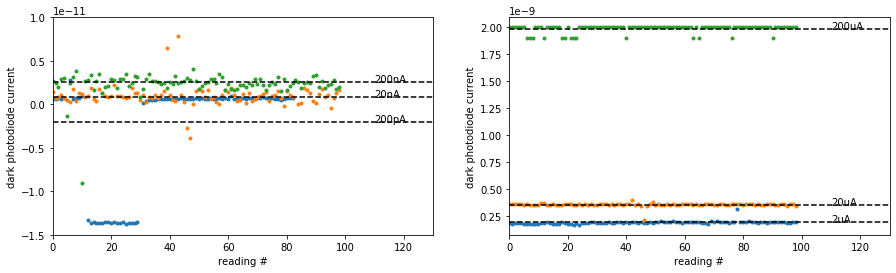

In [9]:
pd_dark_200pA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(58) + ".txt",reg_number=1, material_name='pd_dark_200pA')
pd_dark_20nA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(59) + ".txt",reg_number=1, material_name='pd_dark_20nA')
pd_dark_200nA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(60) + ".txt",reg_number=1, material_name='pd_dark_200nA')
pd_dark_2uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(61) + ".txt",reg_number=1, material_name='pd_dark_2uA')
pd_dark_20uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(62) + ".txt",reg_number=1, material_name='pd_dark_20uA')
pd_dark_200uA_df = get_region_df(reg_filename=f"20220317_arneodo/file(1)" + "{:04d}".format(63) + ".txt",reg_number=1, material_name='pd_dark_200uA')

fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_KC'],'.')
pd_dark_200pA=np.mean(pd_dark_200pA_df['I_KC'])
plt1.axhline(y=pd_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=pd_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_KC'],'.')
pd_dark_20nA=np.mean(pd_dark_20nA_df['I_KC'])
plt1.axhline(y=pd_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=pd_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_KC'],'.')
pd_dark_200nA=np.mean(pd_dark_200nA_df['I_KC'])
plt1.axhline(y=pd_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=pd_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_ylim(-1.5e-11,1e-11)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark photodiode current')

plt2.plot(pd_dark_2uA_df['I_KC'],'.')
pd_dark_2uA=np.mean(pd_dark_2uA_df['I_KC'])
plt2.axhline(y=pd_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=pd_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_KC'],'.')
pd_dark_20uA=np.mean(pd_dark_20uA_df['I_KC'])
plt2.axhline(y=pd_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=pd_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_KC'],'.')
pd_dark_200uA=np.mean(pd_dark_200uA_df['I_KC'])
plt2.axhline(y=pd_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=pd_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark photodiode current')


# Keithley A (monitor) Dark

Text(0, 0.5, 'dark monitor (KA) current')

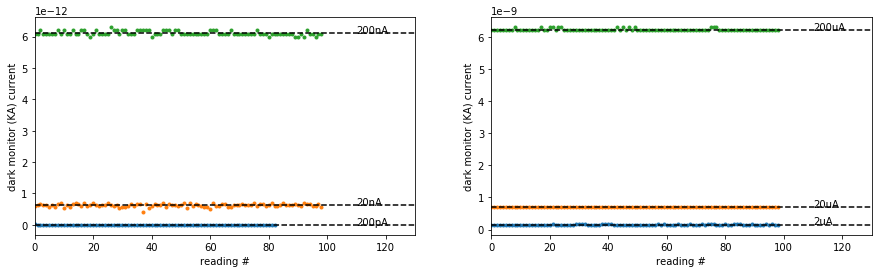

In [10]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_KA'],'.')
KA_dark_200pA=np.mean(pd_dark_200pA_df['I_KA'])
plt1.axhline(y=KA_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KA_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_KA'],'.')
KA_dark_20nA=np.mean(pd_dark_20nA_df['I_KA'])
plt1.axhline(y=KA_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KA_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_KA'],'.')
KA_dark_200nA=np.mean(pd_dark_200nA_df['I_KA'])
plt1.axhline(y=KA_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KA_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark monitor (KA) current')

plt2.plot(pd_dark_2uA_df['I_KA'],'.')
KA_dark_2uA=np.mean(pd_dark_2uA_df['I_KA'])
plt2.axhline(y=KA_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KA_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_KA'],'.')
KA_dark_20uA=np.mean(pd_dark_20uA_df['I_KA'])
plt2.axhline(y=KA_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KA_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_KA'],'.')
KA_dark_200uA=np.mean(pd_dark_200uA_df['I_KA'])
plt2.axhline(y=KA_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KA_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark monitor (KA) current')

# Keithley B (sample) Dark

Text(0, 0.5, 'dark sample (KB) current')

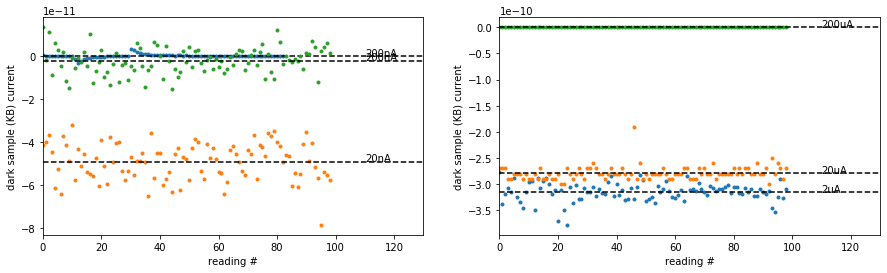

In [11]:
fig, (plt1, plt2) = plt.subplots(1, 2, figsize=(15, 4))

plt1.plot(pd_dark_200pA_df['I_KB'],'.')
KB_dark_200pA=np.mean(pd_dark_200pA_df['I_KB'])
plt1.axhline(y=KB_dark_200pA, color='k', linestyle='--')
plt1.text(s='200pA',x=110,y=KB_dark_200pA)

plt1.plot(pd_dark_20nA_df['I_KB'],'.')
KB_dark_20nA=np.mean(pd_dark_20nA_df['I_KB'])
plt1.axhline(y=KB_dark_20nA, color='k', linestyle='--')
plt1.text(s='20nA',x=110,y=KB_dark_20nA)

plt1.plot(pd_dark_200nA_df['I_KB'],'.')
KB_dark_200nA=np.mean(pd_dark_200nA_df['I_KB'])
plt1.axhline(y=KB_dark_200nA, color='k', linestyle='--')
plt1.text(s='200nA',x=110,y=KB_dark_200nA)

plt1.set_xlim(0,130)
plt1.set_xlabel('reading #')
plt1.set_ylabel('dark sample (KB) current')

plt2.plot(pd_dark_2uA_df['I_KB'],'.')
KB_dark_2uA=np.mean(pd_dark_2uA_df['I_KB'])
plt2.axhline(y=KB_dark_2uA, color='k', linestyle='--')
plt2.text(s='2uA',x=110,y=KB_dark_2uA)

plt2.plot(pd_dark_20uA_df['I_KB'],'.')
KB_dark_20uA=np.mean(pd_dark_20uA_df['I_KB'])
plt2.axhline(y=KB_dark_20uA, color='k', linestyle='--')
plt2.text(s='20uA',x=110,y=KB_dark_20uA)

plt2.plot(pd_dark_200uA_df['I_KB'],'.')
KB_dark_200uA=np.mean(pd_dark_200uA_df['I_KB'])
plt2.axhline(y=KB_dark_200uA, color='k', linestyle='--')
plt2.text(s='200uA',x=110,y=KB_dark_200uA)

plt2.set_xlim(0,130)
plt2.set_xlabel('reading #')
plt2.set_ylabel('dark sample (KB) current')

# Summary of recorded (dark) current offsets:

In [12]:
offsets_data = {'range': ["200pA",'20nA','200nA','2uA','20uA','200uA'], 'KA_offset': [KA_dark_200pA,KA_dark_20nA,KA_dark_200nA,KA_dark_2uA,KA_dark_20uA,KA_dark_200uA], 'KB_offset' : [KB_dark_200pA,KB_dark_20nA,KB_dark_200nA,KB_dark_2uA,KB_dark_20uA,KB_dark_200uA], 'KC_offset': [pd_dark_200pA,pd_dark_20nA,pd_dark_200nA,pd_dark_2uA,pd_dark_20uA,pd_dark_200uA]}
offsets_df = pd.DataFrame(data=offsets_data)
offsets_df

,range,KA_offset,KB_offset,KC_offset
0,200pA,4.385542e-16,3.128313e-14,-2.042240e-12
1,20nA,6.252525e-13,-4.916333e-11,8.050505e-13
2,200nA,6.122222e-12,-2.214141e-12,2.602020e-12
3,2uA,1.529899e-10,-3.148990e-10,1.918485e-10
4,20uA,7.010101e-10,-2.784848e-10,3.545455e-10
5,200uA,6.213131e-09,0.000000e+00,1.985859e-09


# Function to subtract dark offsets from each dataframe:

In [13]:
def subtract_offsets(df_sample,df_offsets):
    length = len(df_sample['phot_E'])
    df_sample['KA_offset'] = np.zeros(length)
    df_sample['KB_offset'] = np.zeros(length)
    df_sample['KC_offset'] = np.zeros(length)


    df_copy = df_sample # I iterate over original dataframe but I write into its copy
    for i in range(len(df_sample)): #iterate over the rows of sample dataframe
        row = df_sample.iloc[[i]] #copy a single row

        if '200pA' in row.iloc[0]['KA_range']: #ASSIGNING KA RANGE
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[0]['KA_offset']
        elif '20nA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[1]['KA_offset']
        elif '200nA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[2]['KA_offset']
        elif '2uA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[3]['KA_offset']
        elif '20uA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[4]['KA_offset']
        elif '200uA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KA_offset'] = df_offsets.iloc[5]['KA_offset']
        else: print("KA range not found!")

        if '200pA' in row.iloc[0]['KB_range']: #ASSIGNING KB RANGE
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[0]['KB_offset']
        elif '20nA' in row.iloc[0]['KB_range']:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[1]['KB_offset']
        elif '200nA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[2]['KB_offset']
        elif '2uA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[3]['KB_offset']
        elif '20uA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[4]['KB_offset']
        elif '200uA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KB_offset'] = df_offsets.iloc[5]['KB_offset']
        else: print("KB range not found!")

        if '200pA' in row.iloc[0]['KC_range']: #ASSIGNING KA RANGE
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[0]['KC_offset']
        elif '20nA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[1]['KC_offset']
        elif '200nA' in row.iloc[0]['KC_range']:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[2]['KC_offset']
        elif '2uA' in row.iloc[0]['KC_range']:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[3]['KC_offset']
        elif '20uA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[4]['KC_offset']
        elif '200uA' in row.iloc[0]['KA_range']:
            df_copy.at[i, 'KC_offset'] = df_offsets.iloc[5]['KC_offset']
        else: print("KC range not found!")

    df_sample = df_copy
    df_sample['I_KA_real'] = df_sample['I_KA'] - df_sample['KA_offset']
    df_sample['I_KB_real'] = df_sample['I_KB'] - df_sample['KB_offset']
    df_sample['I_KC_real'] = df_sample['I_KC'] - df_sample['KC_offset']

    return

# Plot and polyfit of the Photodiode's responsivity function:

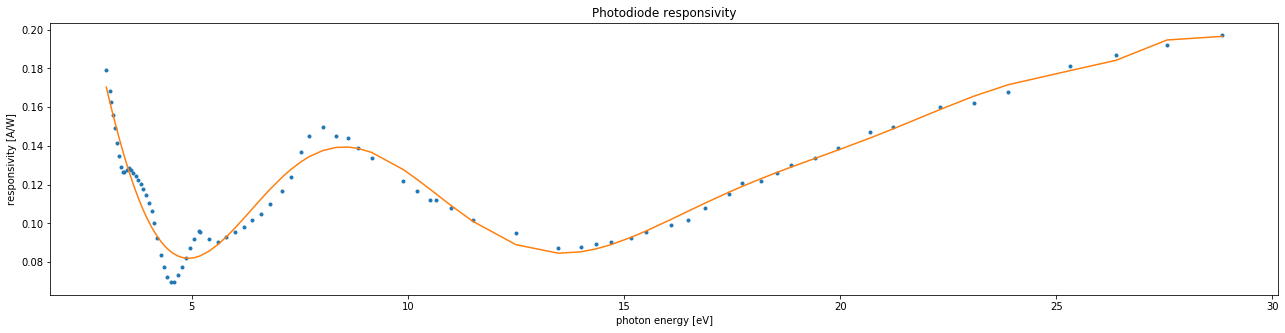

In [14]:
# load photodiode responsivity from a textfile:
ph_eV, wavelength_nm, responsivity = [],[],[] #responsivity in Amperes per Watt!

filename = "axuv_responsivity.txt"
startline = 3 #first two lines are useless

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
for i in range(startline-1,len(copy_lines)-1):
    line = copy_lines[i]

    ph_eV.append(float(line[0]))
    wavelength_nm.append(float(line[1]))
    responsivity.append(float(line[3]))

pd_data = {'phot_E': ph_eV, 'wavelength': wavelength_nm, 'responsivity' : responsivity}
responsivity_df = pd.DataFrame(data=pd_data).sort_values('phot_E')
condition1 = responsivity_df['phot_E'] < 30
condition2 = responsivity_df['phot_E'] > 3
energy_eV_march = responsivity_df[condition1 & condition2]['phot_E'].tolist()
responsivity_march = responsivity_df[condition1 & condition2]['responsivity'].tolist()

figure(figsize=(22, 5))
plt.xlabel('photon energy [eV]')
plt.ylabel('responsivity [A/W]')
plt.title('Photodiode responsivity')
plt.plot(energy_eV_march,responsivity_march,'.')

responsivity_fit_march = np.poly1d(np.polyfit(energy_eV_march, responsivity_march, 10)) #make a polynomial fit for the first region
plt.plot(energy_eV_march, responsivity_fit_march(energy_eV_march), '-', label="polyfit")

test_eV = np.linspace(0,30,1000)
#plt.plot(test_eV, responsivity_fit_march(test_eV), '.')

# Responsivity (August 2021):

(0, 30)

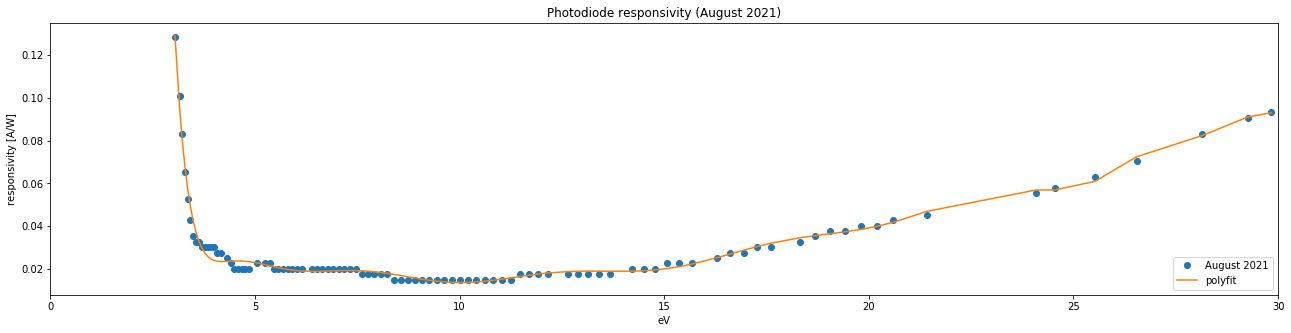

In [15]:
# load photodiode responsivity from a textfile:
lambda_nm, responsivity = [],[] #responsivity in Amperes per Watt!

filename = "sxuv_responsivity.txt"
startline = 3 #first two lines are useless

copy_lines=[]
with open(filename) as f:
    lines = f.readlines()

for line in lines:
    split_line = line.split()
    copy_lines.append(split_line)

    #from each line, extract a name/number and append it into its relevant column
for i in range(startline-1,len(copy_lines)-1):
    line = copy_lines[i]

    lambda_nm.append(float(line[0]))
    responsivity.append(float(line[1]))


pd_data = {'phot_E': convert_nm_to_eV(lambda_nm), 'wavelength': lambda_nm, 'responsivity' : responsivity}
responsivity_df_aug = pd.DataFrame(data=pd_data).sort_values('phot_E')
condition1 = responsivity_df_aug['phot_E'] < 30
condition2 = responsivity_df_aug['phot_E'] > 3
energy_eV_aug = responsivity_df_aug[condition1 & condition2]['phot_E'].tolist()
responsivity_aug = responsivity_df_aug[condition1 & condition2]['responsivity'].tolist()

#plot responsivity
figure(figsize=(22, 5))
plt.plot(energy_eV_aug, responsivity_aug, 'o', label="August 2021")
plt.xlabel('eV')
plt.ylabel('responsivity [A/W]')
plt.title('Photodiode responsivity (August 2021)')

responsivity_fit_aug = np.poly1d(np.polyfit(energy_eV_aug, responsivity_aug, 15)) #make a polynomial fit for the first region
plt.plot(energy_eV_aug, responsivity_fit_aug(energy_eV_aug), '-', label="polyfit")

plt.legend(loc="lower right")
plt.xlim(0,30)


# Comparison of Responsivities (August and March)

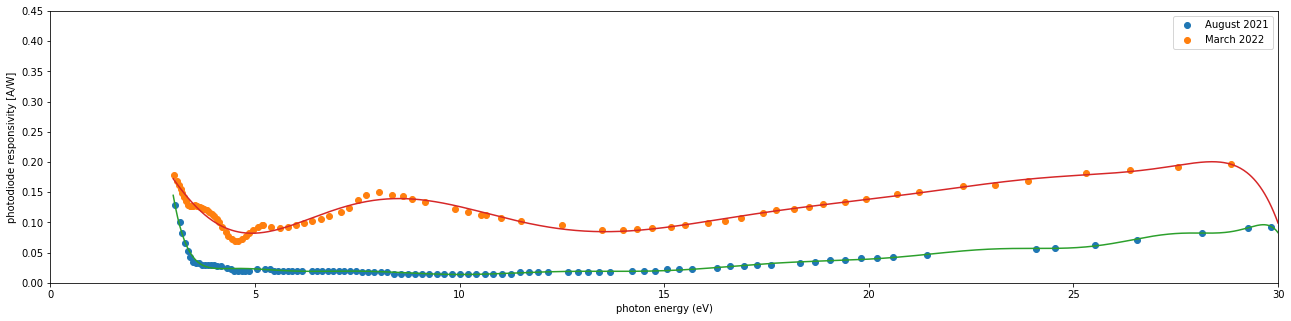

In [16]:
#plot responsivity
figure(figsize=(22, 5))
plt.plot(energy_eV_aug, responsivity_aug, 'o', label="August 2021")
plt.plot(energy_eV_march, responsivity_march, 'o', label="March 2022")

test_eV = np.linspace(3,30,1000)
plt.plot(test_eV,responsivity_fit_aug(test_eV),'-')
plt.plot(test_eV,responsivity_fit_march(test_eV),'-')
plt.ylim(0,0.45)
plt.xlim(0,30)
plt.ylim(0,0.45)
plt.ylabel("photodiode responsivity [A/W]")
plt.xlabel("photon energy (eV)")
plt.legend()


# Ratio of responsivities in the low energy region:

/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3325: RankWarning: Polyfit may be poorly conditioned
  exec(code_obj, self.user_global_ns, self.user_ns)


Text(0.5, 0, 'march/aug responsivity ratio')

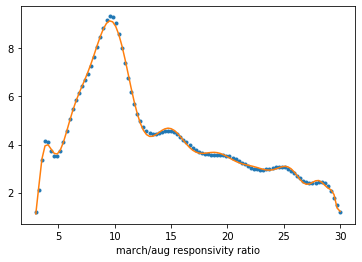

In [17]:
test_eV = np.linspace(3,30,100)
ratio = responsivity_fit_march(test_eV)/responsivity_fit_aug(test_eV)
plt.plot(test_eV,ratio,'.')
ratio_fit = np.poly1d(np.polyfit(test_eV, ratio, 30))
plt.plot(test_eV,ratio_fit(test_eV))
plt.xlabel('photon energy (eV)')
plt.xlabel('march/aug responsivity ratio')

# A function to compute the photoelectric yield:

In [18]:
def compute_yield(mat_df=object,PD_df=object,threshold_lambda=int,pd_data=str,subtract_offset=bool):
    mat_phot_E = np.array(mat_df['phot_E'].tolist())
    PD_phot_E  = np.array(PD_df['phot_E'].tolist())


    if subtract_offset:
        mat_I = np.array(mat_df['I_KB_real'].tolist())
        PD_I  = np.array(PD_df[ 'I_KC_real'].tolist())

        mat_I_monit = np.array(mat_df['I_KA_real'].tolist())
        PD_I_monit  = np.array(PD_df[ 'I_KA_real'].tolist())
    else:
        mat_I = np.array(mat_df['I_KB'].tolist())
        PD_I  = np.array(PD_df[ 'I_KC'].tolist())

        mat_I_monit = np.array(mat_df['I_KA'].tolist())
        PD_I_monit  = np.array(PD_df[ 'I_KA'].tolist())

    print("material df: ",len(mat_phot_E),'\nphotodiode df:',len(PD_phot_E))


    length = min(len(mat_phot_E),len(PD_phot_E))

    #now I need to split the responsivity factor into two since I'm using two different polyfits of the photodiode responsivity
    R = []
    for i in range(length):
        if "march" in pd_data:
            R.append(responsivity_fit_march(mat_phot_E[i]))

        elif "aug" in pd_data:
            R.append(responsivity_fit_aug(mat_phot_E[i]))
        else:
            print("incorrect photodiode data")

    R = np.array(R)

    TEY = (mat_I[:length]/mat_I_monit[:length]) * (PD_I_monit[:length]/PD_I[:length]) * R[:length] * PD_phot_E[:length]
    
    TEY=list(TEY)
    while len(TEY) != len(mat_df):
        TEY.append(0)
    TEY=np.array(TEY)
    
    mat_df['Yield'] = 0
    mat_df['Yield'] = TEY
    return

# Photodiode LOW, COARSE (3-45 eV, 0.5eV step):

In [20]:
PD_low_file_number = 52 
PD_low_N_of_regs = 7
PD_low_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_low_add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

PD_low_df = concate_regions(file_number=PD_low_file_number,N_of_regs=PD_low_N_of_regs,material_name="PD_low",reject_regions=PD_low_reject_regs,add_regions_from_files=PD_low_add_regs_from_files)
subtract_offsets(PD_low_df,offsets_df)
PD_low_df.head()

,phot_E,I_KB,I_KA,I_KC,reg_number,material_name,KA_range,KB_range,KC_range,phot_E_real,KA_offset,KB_offset,KC_offset,I_KA_real,I_KB_real,I_KC_real
0,3.499998,1.947000e-13,-4.300000e-15,2.200000e-10,1,PD_low,20nA,20nA,2uA,1.947000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.295525e-13,4.935803e-11,2.191949e-10
1,3.999990,1.805000e-13,-5.300000e-15,2.180000e-10,1,PD_low,20nA,20nA,2uA,1.805000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.305525e-13,4.934383e-11,2.171949e-10
2,4.499995,1.741000e-13,-2.700000e-15,2.290000e-10,2,PD_low,20nA,20nA,2uA,1.741000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.279525e-13,4.933743e-11,2.281949e-10
3,4.999990,1.729000e-13,-5.700000e-15,2.820000e-10,2,PD_low,20nA,20nA,2uA,1.729000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.309525e-13,4.933623e-11,2.811949e-10
4,5.499981,2.068000e-13,3.200000e-15,2.810000e-10,2,PD_low,20nA,20nA,2uA,2.068000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.220525e-13,4.937013e-11,2.801949e-10


Text(0, 0.5, 'diode current [A]')

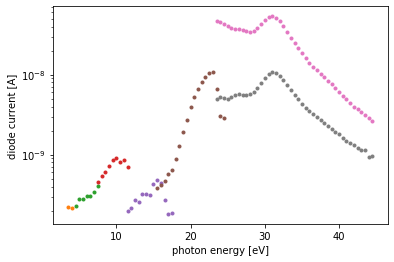

In [21]:
for i in range(8):
    criterion = PD_low_df['reg_number'] == i
    pd_df = PD_low_df.loc[criterion]
    
    plt.plot(pd_df['phot_E'],pd_df['I_KC'],'.')
plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('diode current [A]')

# Photodiode low, AUG 2021 

Text(0, 0.5, 'photodiode current (A)')

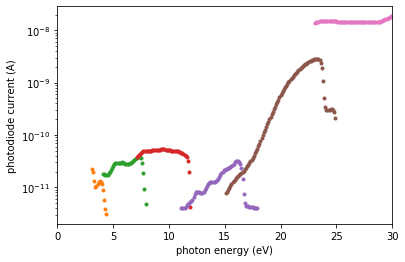

In [22]:
PD_compare_file_number = 14
PD_compare_N_of_regs = 7
PD_compare_reject_regs = [] 
PD_compare_add_regs_from_files = [0]

PD_compare_fine_df = concate_regions_old(file_number=PD_compare_file_number,N_of_regs=PD_compare_N_of_regs,material_name="PD_low_fine",reject_regions=PD_compare_reject_regs,add_regions_from_files=PD_compare_add_regs_from_files)
PD_compare_fine_df['I_KC'] = PD_compare_fine_df['I_KB']
PD_compare_fine_df = PD_compare_fine_df.loc[PD_compare_fine_df['reg_number'] != 7]

def pick_rows(df=object, tolerance=float, around_energies=list): #a function to only pick rows corresponding to 0.5 eV steps:
    temp_df = df.iloc[[0]]
    for i in range(1,len(df)): #iterate over the rows of sample dataframe
            row = df.iloc[[i]] #copy a single row
            for val in around_energies:
                if abs(val-float(row['phot_E'])) < tolerance:
                    temp_df = pd.concat([temp_df,row])
    return  temp_df

#creating a dataframe for august photodiode data, making, picking rows with 0.5 eV step
PD_compare_coarse_df = PD_compare_fine_df.loc[PD_compare_fine_df['reg_number'] != 7] #delete the last region, it appears twice
PD_compare_coarse_df = pick_rows(df=PD_compare_coarse_df,tolerance=0.05,around_energies=np.arange(3,30.5,0.5))

for i in range(8):
    criterion = PD_compare_fine_df['reg_number'] == i
    pd_df = PD_compare_fine_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KC'],'.')
    
plt.yscale('log')
plt.xlim(0,30)
plt.xlabel('photon energy (eV)')
plt.ylabel('photodiode current (A)')

# Photodiode LOW, FINE (3-45 eV, 0.1 step)

In [23]:
PD_low_fine_file_number = 53
PD_low_fine_N_of_regs = 7
PD_low_fine_reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_low_fine_add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

PD_low_fine_df = concate_regions(file_number=PD_low_fine_file_number,N_of_regs=PD_low_fine_N_of_regs,material_name="PD_low_fine",reject_regions=PD_low_fine_reject_regs,add_regions_from_files=PD_low_fine_add_regs_from_files)
subtract_offsets(PD_low_fine_df,offsets_df)
PD_low_fine_df.head()

,phot_E,I_KB,I_KA,I_KC,reg_number,material_name,KA_range,KB_range,KC_range,phot_E_real,KA_offset,KB_offset,KC_offset,I_KA_real,I_KB_real,I_KC_real
0,3.099994,1.232000e-13,-1.600000e-15,2.180000e-10,1,PD_low_fine,20nA,20nA,2uA,1.232000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.268525e-13,4.928653e-11,2.171949e-10
1,3.199996,1.792000e-13,-6.800000e-15,2.230000e-10,1,PD_low_fine,20nA,20nA,2uA,1.792000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.320525e-13,4.934253e-11,2.221949e-10
2,3.300000,1.622000e-13,-8.700000e-15,2.460000e-10,1,PD_low_fine,20nA,20nA,2uA,1.622000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.339525e-13,4.932553e-11,2.451949e-10
3,3.399999,2.123000e-13,-2.300000e-15,2.190000e-10,1,PD_low_fine,20nA,20nA,2uA,2.123000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.275525e-13,4.937563e-11,2.181949e-10
4,3.500002,2.148000e-13,-2.900000e-15,2.410000e-10,1,PD_low_fine,20nA,20nA,2uA,2.148000e-13,6.252525e-13,-4.916333e-11,8.050505e-13,-6.281525e-13,4.937813e-11,2.401949e-10


# Comparison of August and March photodiode currents (accounting for different responsivities)

(0, 30)

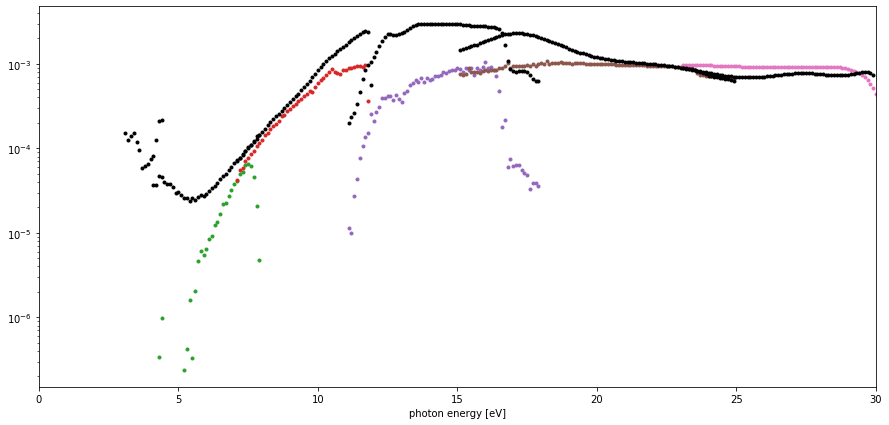

In [61]:
figure(figsize=(15, 7))
for i in range(7):
    criterion = PD_low_fine_df['reg_number'] == i
    pd_df_march = PD_low_fine_df.loc[criterion]
    ph_E = np.array(pd_df_march['phot_E'].tolist())
    I_KC = np.array(pd_df_march['I_KC'].tolist())
    I_KA = np.array(pd_df_march['I_KA'].tolist())
    plt.plot(ph_E,I_KA/I_KC*responsivity_fit_march(ph_E),'.')

for i in range(7):
    criterion = PD_compare_fine_df['reg_number'] == i
    pd_df_aug = PD_compare_fine_df.loc[criterion]
    ph_E = np.array(pd_df_aug['phot_E'].tolist())
    I_KB = np.array(pd_df_aug['I_KB'].tolist()) #back in August, we measured photodiode current on KB, not KC
    I_KA = np.array(pd_df_aug['I_KA'].tolist())
    plt.plot(ph_E,I_KA/I_KB*responsivity_fit_aug(ph_E),'.',color="black")


plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.xlim(0,30)

# Photodiode HIGH (40-1500 eV):

Text(0, 0.5, 'diode current [A]')

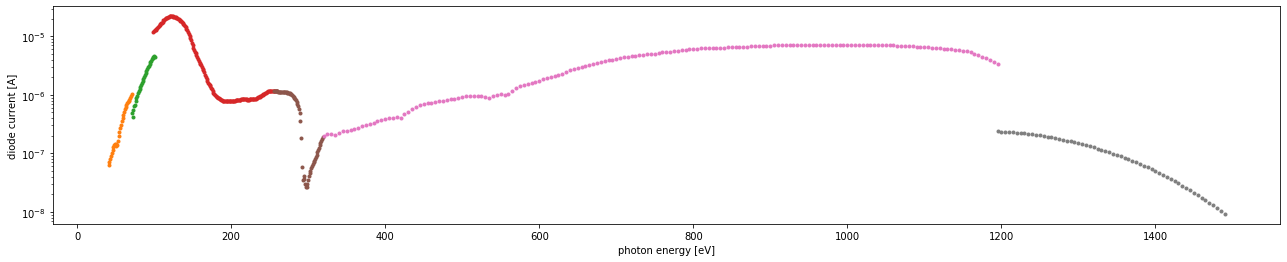

In [27]:
PD_high_file_number = 47
PD_high_N_of_regs = 7
PD_high_reject_regs = [4,7] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
PD_high_add_regs_from_files = [0,48] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

PD_high_df = concate_regions(file_number=PD_high_file_number,N_of_regs=PD_high_N_of_regs,material_name='PD_high',reject_regions=PD_high_reject_regs,add_regions_from_files=PD_high_add_regs_from_files)
subtract_offsets(PD_high_df,offsets_df)

figure(figsize=(22, 4))
for i in range(12):
    criterion = PD_high_df['reg_number'] == i
    pd_df = PD_high_df.loc[criterion]
    
    plt.plot(pd_df['phot_E'],pd_df['I_KC'],'.')


plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('diode current [A]')

# Gold LOW (3-45eV):

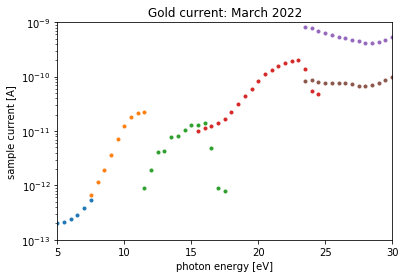

In [46]:
mat_name = 'Gold_low'
mat_file_number = 12
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

Gold_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Gold_low_df,offsets_df)

for i in range(2,8):
    criterion = Gold_low_df['reg_number'] == i
    pd_df = Gold_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')
plt.xlim(5,30)
plt.ylim(1e-13,1e-9)
plt.title('Gold current: March 2022')
plt.savefig('plots/Au_current_March.png', dpi=300)

material df:  136 
photodiode df: 136


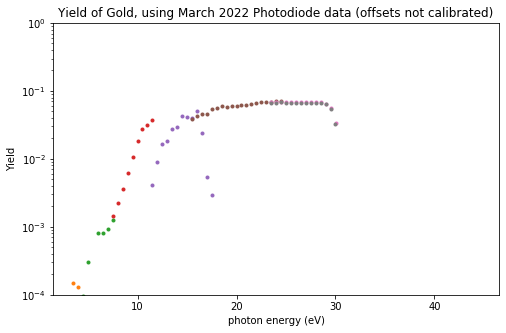

In [38]:
compute_yield(mat_df=Gold_low_df,PD_df=PD_low_df,threshold_lambda=80,pd_data="march",subtract_offset=False)

figure(figsize=(8, 5))
for i in range(8):
    criterion = Gold_low_df['reg_number'] == i
    pd_df = Gold_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.ylim(1e-4,1)
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.title('Yield of Gold, using March 2022 Photodiode data (offsets not calibrated)')
plt.savefig('plots/Au_test_march22_PD.png', dpi=300)


# Gold Low, Coarse, March 2022 Sample data, Aug 2021 photodiode data

material df:  136 
photodiode df: 64


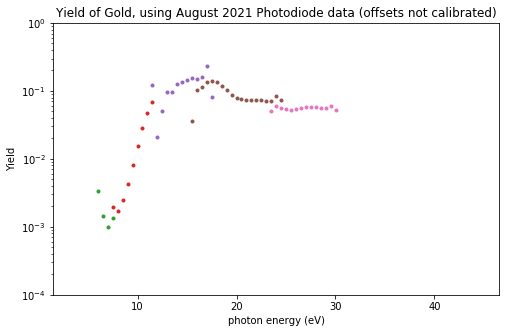

In [41]:
mat_name = 'Gold_low_Aug'
mat_file_number = 12
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

Gold_Aug_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
#subtract_offsets(Gold_Aug_df,offsets_df)

compute_yield(mat_df=Gold_Aug_df,PD_df=PD_compare_coarse_df,threshold_lambda=80,pd_data="aug",subtract_offset=False)
figure(figsize=(8, 5))

for i in range(7):
    criterion = Gold_Aug_df['reg_number'] == i
    pd_df = Gold_Aug_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.ylim(1e-4,1)
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.title('Yield of Gold, using August 2021 Photodiode data (offsets not calibrated)')
plt.savefig('plots/Au_test_aug21_PD.png', dpi=300)

# Gold HIGH (40-1500 eV)

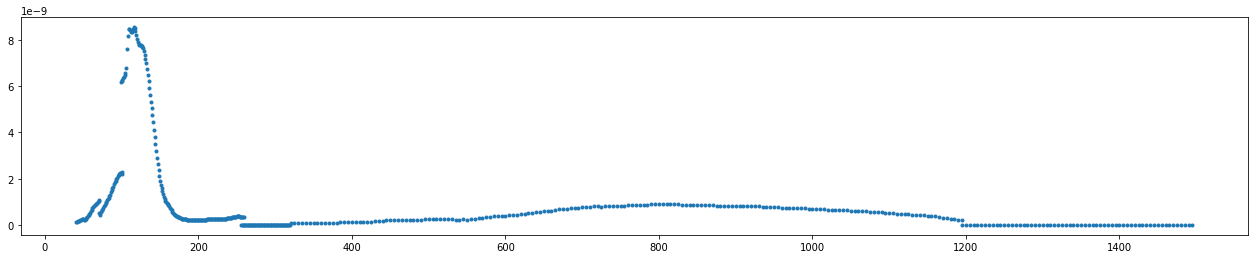

In [151]:
mat_name = 'Gold_high'
mat_file_number = 10
mat_N_of_regs = 6
reject_regs = [5,6] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves! (in order!)
add_regs_from_files = [11,11] #number of files from which each respective saturated region shall be substituted from (set 0 if it's supposed to stay empty)

Gold_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
#subtract_offsets(Gold_high_df,offsets_df)

figure(figsize=(22, 4))
plt.plot(Gold_high_df['phot_E'],Gold_high_df['I_KB'],'.')

In [152]:
compute_yield(mat_df=Gold_high_df,PD_df=PD_high_df,threshold_lambda=80,pd_data="march")
Gold_high_df.head()

material df:  524 
photodiode df: 523


,phot_E,I_KB,I_KA,I_KC,reg_number,material_name,KA_range,KB_range,KC_range,phot_E_real,Yield
0,40.999796,1.316700e-10,4.829000e-11,NaN,1,Gold_high,200pA,200pA,200nA,1.316700e-10,-348.595870
1,42.000083,1.453100e-10,5.430000e-11,NaN,1,Gold_high,200pA,200pA,200nA,1.453100e-10,-539.489681
2,43.000074,1.591000e-10,6.061000e-11,NaN,1,Gold_high,200pA,200pA,200nA,1.591000e-10,-806.766138
3,43.999919,1.735400e-10,6.707000e-11,NaN,1,Gold_high,200pA,200pA,200nA,1.735400e-10,-1170.137830
4,44.999755,1.897100e-10,7.402000e-11,NaN,1,Gold_high,200pA,200pA,200nA,1.897100e-10,-1679.738809


/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  import sys
/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  


(0.8912509381337456, 1)

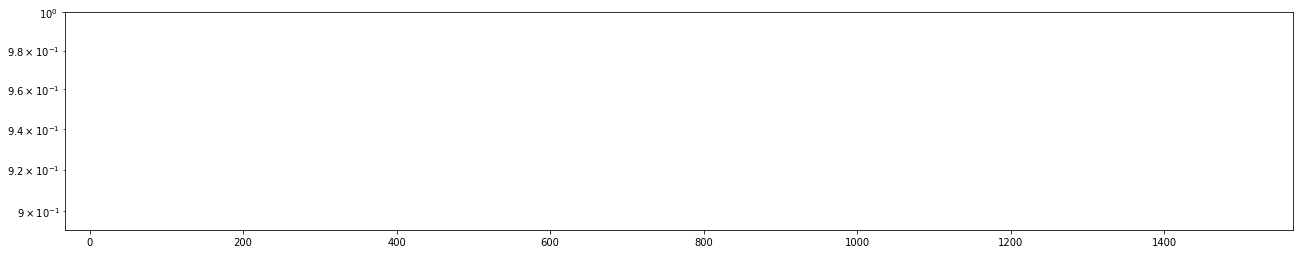

In [153]:


figure(figsize=(22, 4))
for i in range(8):
    criterion = Gold_high_df['reg_number'] == i
    pd_df = Gold_high_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
#plt.plot(convert_eV_to_nm(phot_E),Y,'.')
plt.yscale('log')
plt.ylim(0,1)

# Mg Alloy LOW (fine, 3-45 eV, 0.1eV step)

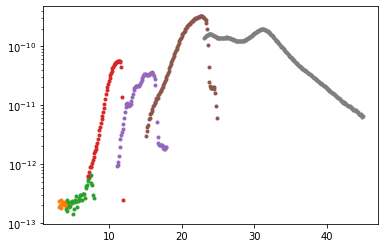

In [156]:
mat_name = 'Mg_alloy_low'
mat_file_number = 24
mat_N_of_regs = 7
reject_regs = [5,6] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [26,0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

Mg_alloy_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
#subtract_offsets(Mg_alloy_low_df,offsets_df)

for i in range(8):
    criterion = Mg_alloy_low_df['reg_number'] == i
    pd_df = Mg_alloy_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB'],'.')
plt.yscale('log')

material df:  488 
photodiode df: 708


(1e-05, 1)

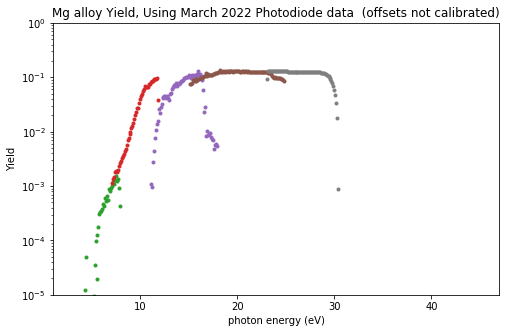

In [157]:
compute_yield(mat_df=Mg_alloy_low_df,PD_df=PD_low_fine_df,threshold_lambda=80,pd_data="march")
Mg_alloy_low_phot_E = np.array(Mg_alloy_low_df['phot_E'].tolist())

figure(figsize=(8, 5))
for i in range(8):
    criterion = Mg_alloy_low_df['reg_number'] == i
    pd_df = Mg_alloy_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
#plt.ylim(1e-5,1)
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.title('Mg alloy Yield, Using March 2022 Photodiode data  (offsets not calibrated)')
plt.savefig('plots/Mg_alloy_test_march22_PD.png', dpi=300)
plt.ylim(1e-5,1)

# Mg alloy fine, using AUG 2021 photodiode

material df:  488 
photodiode df: 339


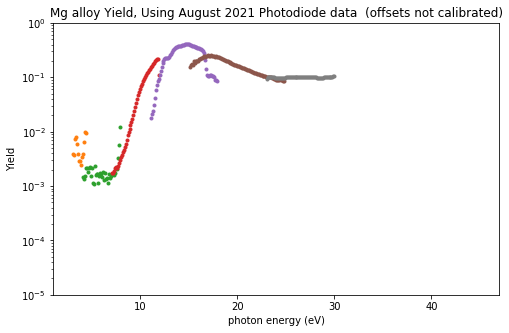

In [33]:
compute_yield(mat_df=Mg_alloy_low_df,PD_df=PD_compare_fine_df,threshold_lambda=80,pd_data="aug")
Mg_alloy_low_phot_E = np.array(Mg_alloy_low_df['phot_E'].tolist())

figure(figsize=(8, 5))
for i in range(8):
    criterion = Mg_alloy_low_df['reg_number'] == i
    pd_df = Mg_alloy_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
plt.yscale('log')
plt.ylim(1e-5,1)
plt.xlabel('photon energy (eV)')
plt.ylabel('Yield')
plt.title('Mg alloy Yield, Using August 2021 Photodiode data  (offsets not calibrated)')
plt.savefig('plots/Mg_alloy_test_Aug21_PD.png', dpi=300)

# Mg Alloy HIGH (40-1500 eV, 0.5eV step)

material df:  524 
photodiode df: 523


/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.


(0.0008058527341428618, 1)

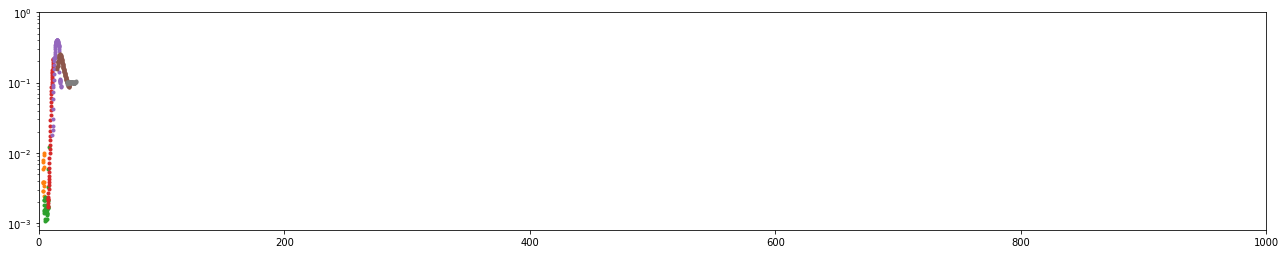

In [34]:
mat_name = 'Mg_alloy_high'
mat_file_number = 19
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

Mg_alloy_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(Mg_alloy_high_df,offsets_df)

Y_Mg_alloy_high = compute_yield(mat_df=Mg_alloy_high_df,PD_df=PD_high_df,threshold_lambda=80,pd_data="march")
phot_E = np.array(PD_high_df['phot_E'].tolist())

figure(figsize=(22, 4))

for i in range(8):
    criterion = Mg_alloy_low_df['reg_number'] == i
    pd_df = Mg_alloy_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')
for i in range(8):
    criterion = Mg_alloy_high_df['reg_number'] == i
    pd_df = Mg_alloy_high_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')

plt.yscale('log')
plt.xlim(0,1000)
plt.ylim(0,1)

# ITO Radiator, LOW 

Text(0, 0.5, 'sample current [A]')

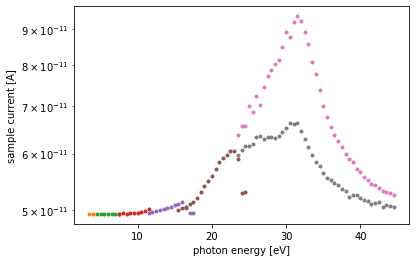

In [35]:
mat_name = 'ITO_radiator_low'
mat_file_number = 22
mat_N_of_regs = 7
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

ITO_radiator_low_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_radiator_low_df,offsets_df)

for i in range(8):
    criterion = ITO_radiator_low_df['reg_number'] == i
    pd_df = ITO_radiator_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')

material df:  136 
photodiode df: 136


/Users/sebastiankalos/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempted to set non-positive bottom ylim on a log-scaled axis.
Invalid limit will be ignored.
  # Remove the CWD from sys.path while we load stuff.


(3.5896168838246996e-05, 1)

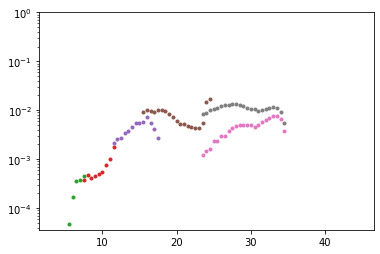

In [36]:
Y_ITO_radiator_low = compute_yield(mat_df=ITO_radiator_low_df,PD_df=PD_low_df,threshold_lambda=80,pd_data="march")
ITO_radiator_low_phot_E = np.array(ITO_radiator_low_df['phot_E'].tolist())

for i in range(8):
    criterion = ITO_radiator_low_df['reg_number'] == i
    pd_df = ITO_radiator_low_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')

plt.yscale('log')
plt.ylim(0,1)

# ITO Radiator High

Text(0, 0.5, 'sample current [A]')

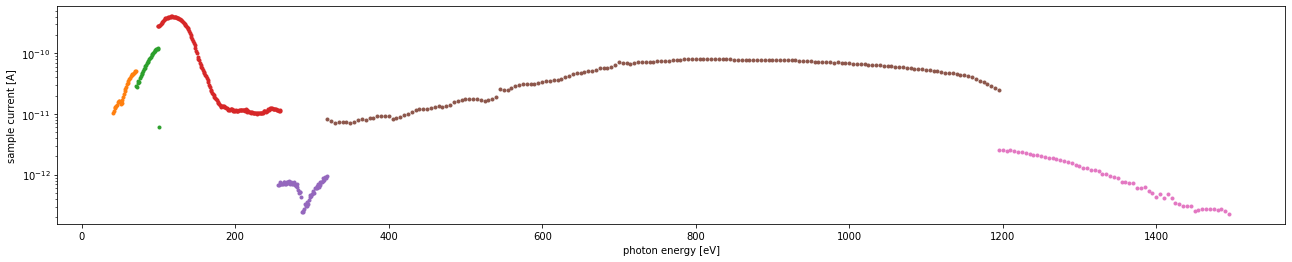

In [37]:
mat_name = 'ITO_radiator_high'
mat_file_number = 21
mat_N_of_regs = 6
reject_regs = [] #a list of regions that saturated (or just need to be removed) in the respective scan - indexed from 1, as in the files themselves!
add_regs_from_files = [0] #number of file from which the saturated regions shall be substituted from (set 0 if it's supposed to stay empty)

ITO_radiator_high_df = concate_regions(file_number=mat_file_number,N_of_regs=mat_N_of_regs,material_name=mat_name,reject_regions=reject_regs,add_regions_from_files=add_regs_from_files)
subtract_offsets(ITO_radiator_high_df,offsets_df)

figure(figsize=(22, 4))
for i in range(8):
    criterion = ITO_radiator_high_df['reg_number'] == i
    pd_df = ITO_radiator_high_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['I_KB_real'],'.')

plt.yscale('log')
plt.xlabel('photon energy [eV]')
plt.ylabel('sample current [A]')

In [38]:
Y_ITO_radiator_high = compute_yield(mat_df=ITO_radiator_high_df,PD_df=PD_high_df,threshold_lambda=80)
ITO_radiator_high_phot_E = np.array(ITO_radiator_high_df['phot_E'].tolist())

figure(figsize=(22, 4))
for i in range(8):
    criterion = ITO_radiator_high_df['reg_number'] == i
    pd_df = ITO_radiator_high_df.loc[criterion]
    plt.plot(pd_df['phot_E'],pd_df['Yield'],'.')

plt.yscale('log')
plt.ylim(0,1)

material df:  524 
photodiode df: 523


TypeError: argument of type 'type' is not iterable